File used for testing the functions in the repository

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd

<h2>Generating simulated data<h2>

In [11]:
from source.Data_generation import DataLoader

In [12]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/all_data_003.csv')

# Usage example:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.125549, 4.5012, 13.7206, 9.70757, 9.24363, 8.84905, 8.37535, 7.8264, 7.84643, 8.74946, 8.4736, 8.5893, 9.00677, 8.93431, 8.7004, 8.79878, 8.63712, 8.86024, 8.56235, 8.77035, 8.93855, 8.96577], 'gt_parameters_list': [0.13, 0.014, 0.025, 0.05]}


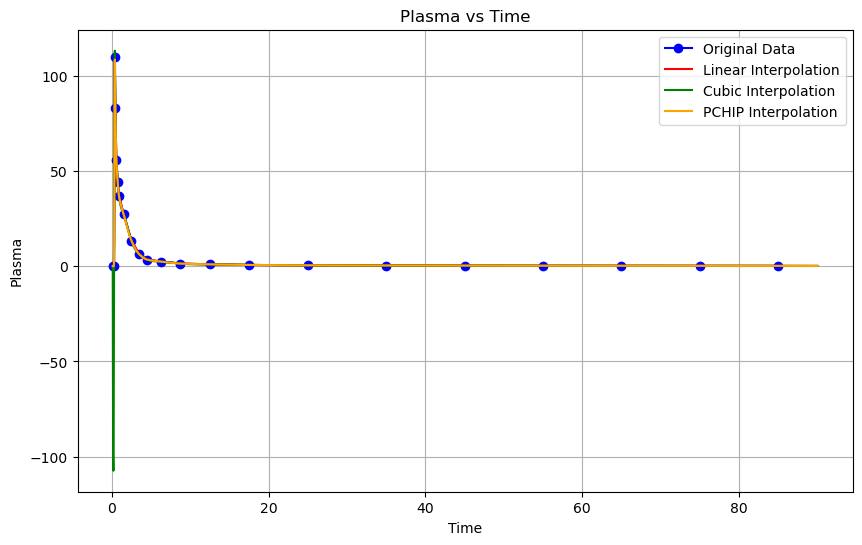

In [13]:
from source.Data_generation import equidistant_interpolation, plot_interpolations

num_equidistant_points = 2048
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['pl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['pl_list'], 
                    new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

<h3> IRF <h3>

In [14]:
from source.Data_generation import IRF

IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)


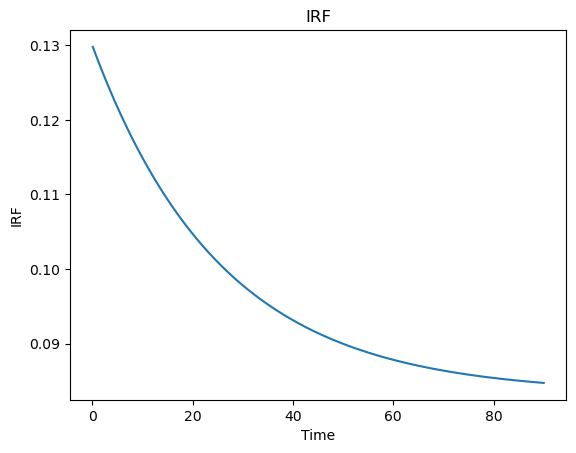

In [15]:
plt.plot(new_rtim, IRF_values)
plt.xlabel('Time')
plt.ylabel('IRF')
plt.title('IRF')
plt.show()

<h2> C Tissue <h2>

In [16]:
def c_tissue_torch(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values.
    """
    # Convert lists to PyTorch tensors and add an extra dimension to match the expected input shape for F.conv1d (Batch, Channel, Length)
    IRF_tensor = torch.tensor(IRF_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Perform 1D convolution. Note that we need to flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    # Use padding to control the output size; here, 'same' equivalence is achieved with manual calculation for padding.
    padding_size = (len(IRF_values) - 1) // 2
    simulated_c_tissue_values = F.conv1d(pchip_pl_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)

    # Truncate or pad the result to match the desired number of points (if necessary)
    num_points = len(IRF_values)
    if simulated_c_tissue_values.shape[-1] > num_points:
        simulated_c_tissue_values = simulated_c_tissue_values[..., :num_points]
    elif simulated_c_tissue_values.shape[-1] < num_points:
        # This case might not occur in this particular setup, but it's here for completeness
        padding = num_points - simulated_c_tissue_values.shape[-1]
        simulated_c_tissue_values = F.pad(simulated_c_tissue_values, (0, padding))

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary dimensions before returning
    return normalized_result_tensor.squeeze()


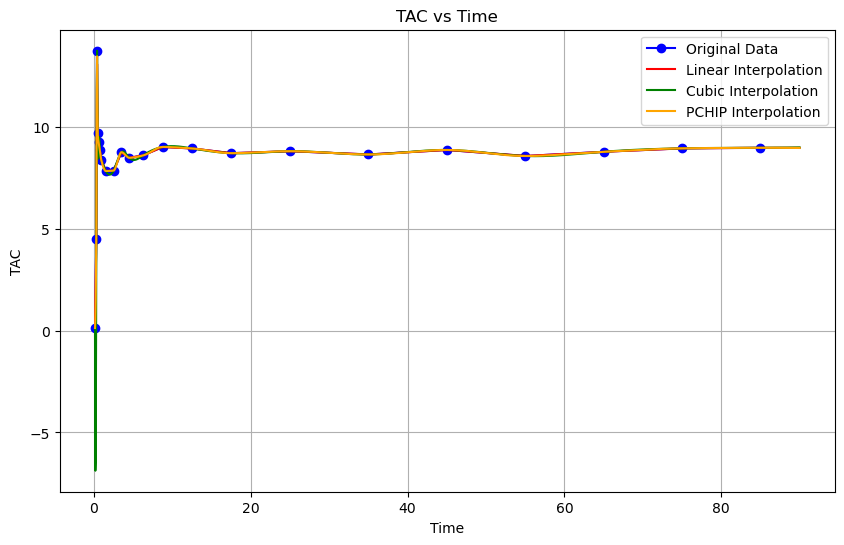

In [17]:
# Get the interpolated tac values
new_rtim, linear_tac, cubic_tac, pchip_tac = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['tac_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['tac_list'], 
                    new_rtim, linear_tac, cubic_tac, pchip_tac, 'TAC')

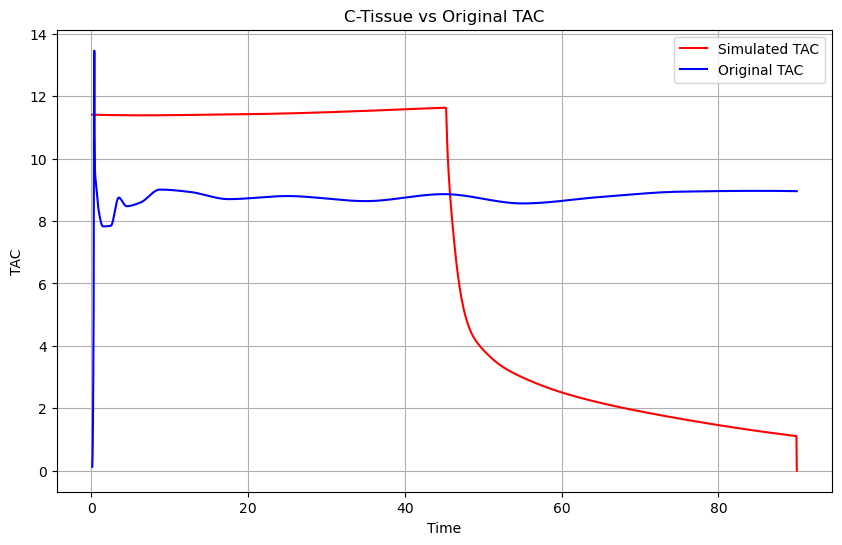

In [18]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue_torch(IRF_values, pchip_pl, dt)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

<h3> Scipy <h3>

In [19]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    list: The simulated C_Tissue values.
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')[:num_points]

    # Normalize the convolution result
    normalized_c_tissue = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_c_tissue


In [20]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

#print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 2048
IRF: 2048
2048


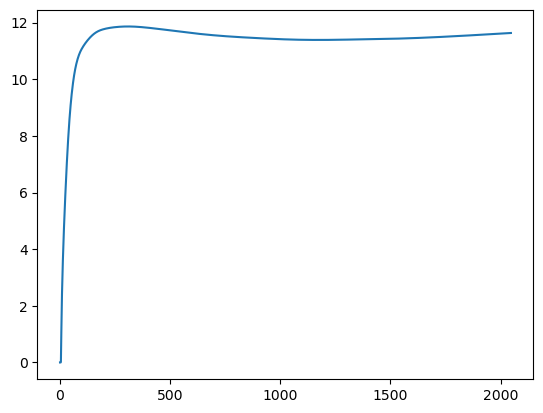

In [21]:
#Divide simulated tac values by constant
#simulated_c_tissue_values = [x / 1.238 for x in simulated_c_tissue_values]

plt.plot(simulated_c_tissue_values)
plt.show()

<h2>Simulated TAC <h2>

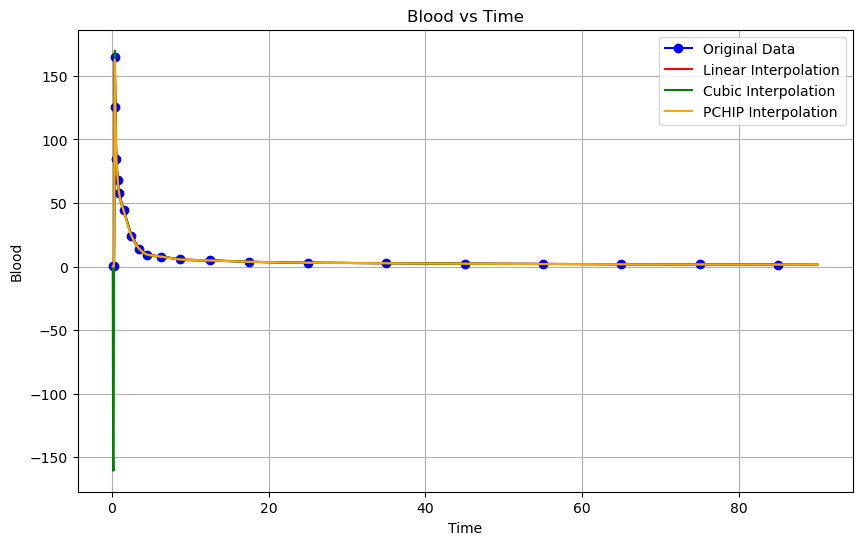

In [22]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [23]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values
    

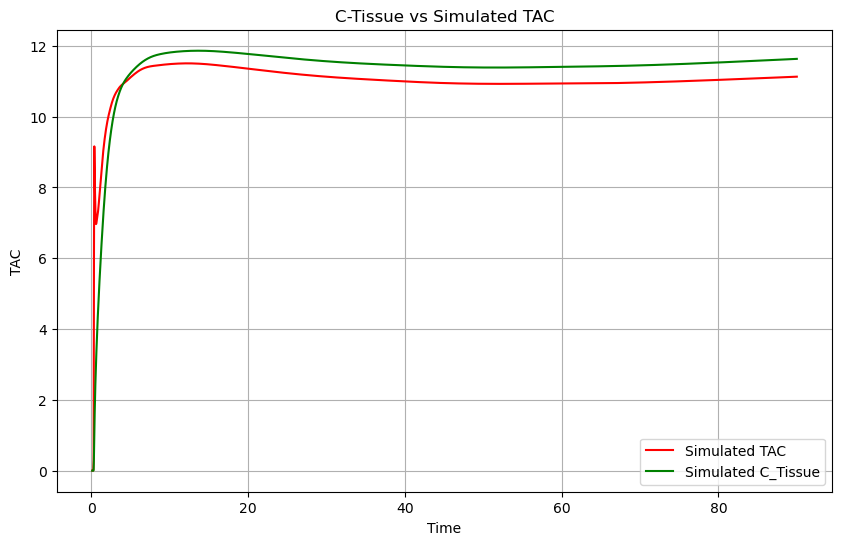

In [24]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()

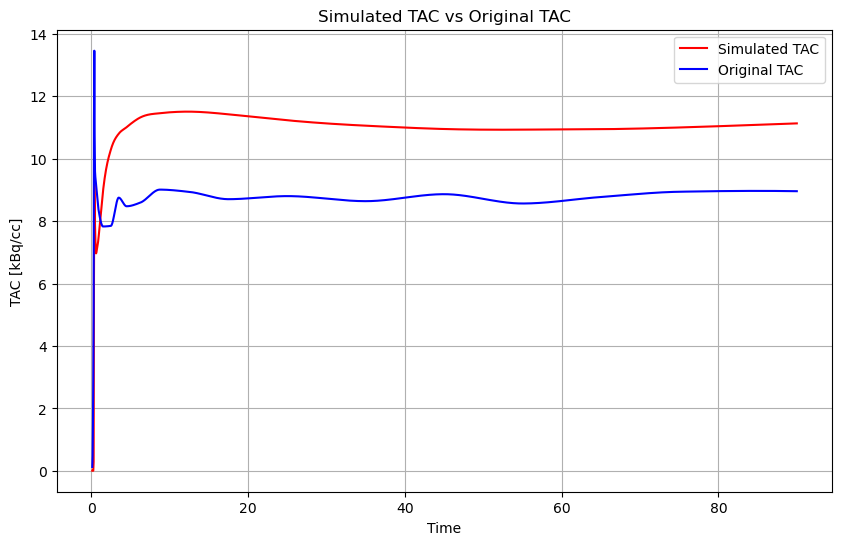

In [25]:
# Plot the simulated TAC values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC [kBq/cc]')
plt.title('Simulated TAC vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

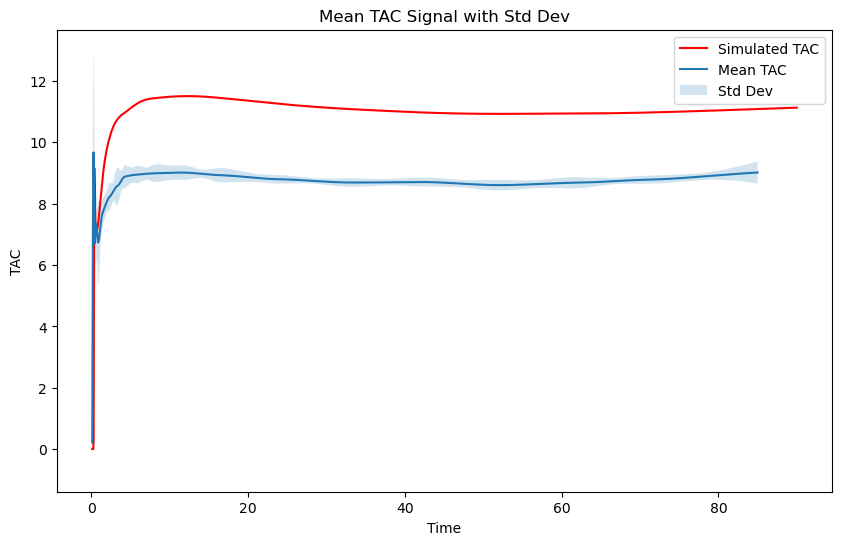

In [26]:
# Initialize lists to store interpolated TAC signals
all_linear_tac = []

# Iterate over the first 25 rows of the DataFrame
for i in range(25):
    data_from_row = DataLoader(i, df)  # Adjust this if DataLoader usage is different
    # Apply equidistant interpolation to each row
    _, _, _, pchip_tac = equidistant_interpolation(data_from_row['rtim_list'],
                                                    data_from_row['tac_list'],
                                                    num_equidistant_points)
    # Append the interpolated signal to the list
    all_linear_tac.append(pchip_tac)

# Convert the list of arrays into a 2D numpy array for easier manipulation
all_linear_tac = np.array(all_linear_tac)

# Calculate the mean and standard deviation across the 25 signals
mean_tac = np.mean(all_linear_tac, axis=0)
std_tac = np.std(all_linear_tac, axis=0)

# Create the time points for plotting, assuming equidistant spacing
time_points = np.linspace(min(data_from_row['rtim_list']), max(data_from_row['rtim_list']), num_equidistant_points)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(time_points, mean_tac, label='Mean TAC')
plt.fill_between(time_points, mean_tac-std_tac, mean_tac+std_tac, alpha=0.2, label='Std Dev')
plt.title('Mean TAC Signal with Std Dev')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.legend()
plt.show()


<h2> Noise <h2>

In [27]:
def adding_noise_simple(simulated_tac_values, new_rtim, original_time, COVi=None):
    """
    Adds normal noise to the simulated TAC values.

    Parameters:
    simulated_tac_values (list): The simulated TAC values.
    new_rtim (list): The new resampled time points.
    original_time (list): The original time points.
    COVi (float): The COVi value.

    Returns:
    list: The noisy TAC values.
    list: The added noise.
    float: The approximate COVi value.
    """
    # Convert inputs to numpy arrays for efficient computation
    simulated_tac_values = np.array(simulated_tac_values)
    new_rtim = np.array(new_rtim)
    original_time = np.array(original_time)

    # Get the indices of the closest points in original time to the new resampled time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in original_time]
    
    # Select the corresponding TAC values based on the closest indices
    tac_values_at_closest_indices = simulated_tac_values[closest_indices]

    # Get the last three TAC values
    last_three_tac = tac_values_at_closest_indices[-3:]

    # Calculate the standard deviation using the last three TAC values
    std_dev = np.std(last_three_tac)

    # Calculate the mean of the last three TAC values
    mean = np.mean(last_three_tac)

    # Calculate approximate COVi:
    approx_COVi = std_dev / mean
    
    # Calculate the noise
    if COVi is not None: # If COVi is provided, use it to calculate the noise
        noise = np.random.normal(0, COVi * mean, len(simulated_tac_values))
    else: # If COVi is not provided, use the standard deviation to calculate the noise
        noise = np.random.normal(0, std_dev, len(simulated_tac_values))
        
    # Add the noise to the simulated TAC values
    noisy_tac = simulated_tac_values + noise

    return noisy_tac, noise, approx_COVi

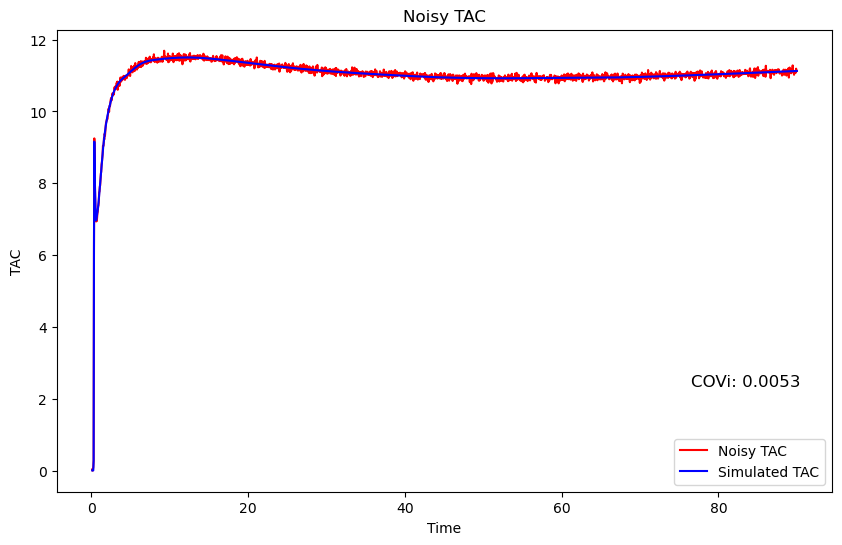

In [28]:
noisy_tac, noise, COVi = adding_noise_simple(simulated_tac_values, new_rtim, data_from_row['rtim_list'])

# Plot the noisy TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, noisy_tac, label='Noisy TAC', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC')
plt.text(x=max(new_rtim) * 0.85, y=max(noisy_tac) * 0.2, s=f'COVi: {COVi:.4f}', fontsize=12, color='black')
plt.legend()
plt.show()

In [29]:
def adding_noise_advanced(simulated_tac_values, new_rtim, type='Normal'):
    """
    Adds noise to the simulated TAC values in a more advanced way. The variance of the noise is calculated for each tac window.

    Parameters:
    simulated_tac_values (list): The simulated TAC values.
    new_rtim (list): The new time points.
    type (str): The type of noise to add. Either 'Poisson' or 'Normal'.

    Returns:
    list: The simulated TAC values with added noise.
    list: The added noise.
    """
    # List of original time points
    times = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85]
    lengths = [0.166667, 0.083333, 0.083333, 0.125, 0.166667, 0.166667, 0.583333, 1, 1, 1, 1.75, 1.5, 3.75, 5, 7.5, 10, 10, 10, 10, 10, 10, 10]

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in times]

    # Calculate the mean and standard deviation of the TAC values in each window
    tac_mean_values = []
    tac_std_dev_values = []
    for i in range(len(times)):
        if i == len(times) - 1:
            # Last interval
            interval_tac = simulated_tac_values[closest_indices[i]:]
        else:
            interval_tac = simulated_tac_values[closest_indices[i]:closest_indices[i+1]]
        tac_mean_values.append(np.mean(interval_tac))
        tac_std_dev_values.append(np.std(interval_tac))
    
    # Add noise to each window
    noisy_tac = []
    noise = []
    for i in range(len(times)):
        # Determine start index
        start_index = closest_indices[i]
        
        # Determine end index: If it's the last element, slice to the end of the array. Otherwise, use the next closest index.
        if i == len(times) - 1:
            end_index = None 
        else:
            end_index = closest_indices[i + 1]
        
        # Slicing tac_window and corresponding new_rtim values
        tac_window = simulated_tac_values[start_index:end_index]
        rtim_window = new_rtim[start_index:end_index]
        
        # Calculate the decay correction factor
        decay = np.log(2) / 109.8 # Fluorine-18 half-life is 109.8 minutes
        F_decay = 1 * np.exp(-decay * rtim_window)
        dcfi = np.trapz(F_decay, rtim_window) / lengths[i]

        # Calculate Ti
        Ti = tac_mean_values[i] * lengths[i] / dcfi

        # Calculate the local variance
        local_variance = (dcfi**2 / (lengths[i]**2)) * Ti
        
        # Generate the noise
        if type == 'Poisson':
            #local_noise = np.random.poisson(0.02 * tac_mean_values[i], size=len(tac_window))
            local_noise = np.random.poisson(np.sqrt(local_variance), size=len(tac_window))
        elif type == 'Normal':
            #local_noise = np.random.normal(0, 0.02 * tac_mean_values[i], size= len(tac_window))
            local_noise = np.random.normal(0, np.sqrt(local_variance), size=len(tac_window))
        
        noise += local_noise.tolist()

    # Add the noise to the simulated TAC values
    simulated_tac_values = np.array(simulated_tac_values)
    noise = np.array(noise)
    noisy_tac = simulated_tac_values + noise
        
    return noisy_tac, noise

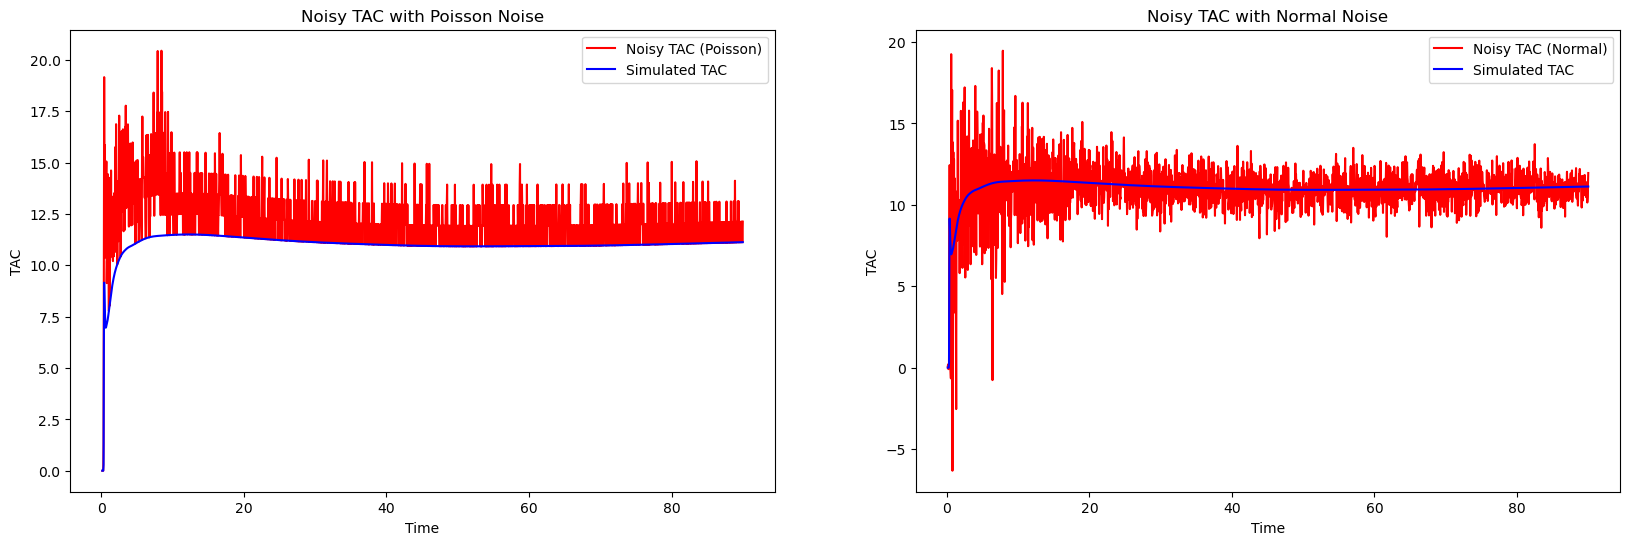

In [30]:
# First, generate noisy TAC values with Poisson noise
noisy_tac_poisson, noise_poisson = adding_noise_advanced(simulated_tac_values, new_rtim, 'Poisson')

# Then, generate noisy TAC values with Normal noise
noisy_tac_normal, noise_normal = adding_noise_advanced(simulated_tac_values, new_rtim, 'Normal')

# Plot both noisy TAC values side by side
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed

# Plot for Poisson noise
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_poisson, label='Noisy TAC (Poisson)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Poisson Noise')
plt.legend()

# Plot for Normal noise
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_normal, label='Noisy TAC (Normal)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Normal Noise')
plt.legend()

plt.show()


<h3>  Generate signal <h3>

In [31]:
def generate_tac(data_row, num_points, type='Simple', COVi=None):
    """
    Generates the TAC signal for the given data row.

    Parameters:
    data_row (pd.Series): The data row containing the required information.
    num_points (int): The number of points to generate.
    type (str): The type of noise to add. Either 'Simple' or 'Advanced'.
    COVi (float): The COVi value.

    Returns:
    list: The new time points.
    list: The simulated TAC values.
    list: The generated TAC signal.
    """
    # Interpolate the required signals using PCHIP
    new_rtim, _, _, pchip_pl = equidistant_interpolation(data_row['rtim_list'], data_row['pl_list'], num_points)
    _, _, _, pchip_bl = equidistant_interpolation(data_row['rtim_list'], data_row['tac_list'], num_points)

    # Calculate the IRF values
    IRF_values = IRF(data_row['gt_parameters_list'], new_rtim)

    # Calculate the C_Tissue values
    dt = new_rtim[1] - new_rtim[0]
    simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

    # Calculate the simulated TAC values
    simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_row['gt_parameters_list'], pchip_bl)

    # Add noise to the simulated TAC values
    if type == 'Simple': # Use the simple noise addition method
        noisy_tac, _, _ = adding_noise_simple(simulated_tac_values, new_rtim, data_row['rtim_list'], COVi)
    elif type == 'Advanced': # Use the advanced noise addition method
        noisy_tac, _ = adding_noise_advanced(simulated_tac_values, new_rtim, 'Normal')

    return new_rtim, simulated_tac_values, noisy_tac

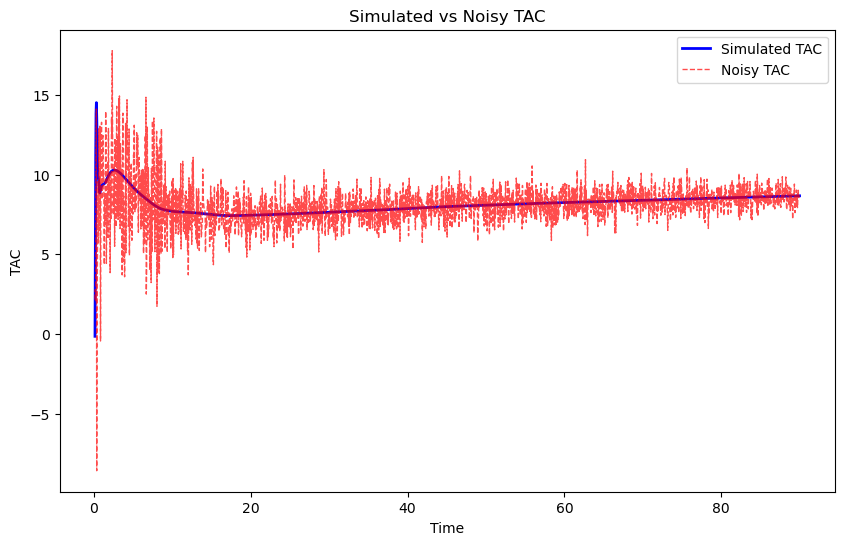

In [32]:
# Generate the TAC signal for the first row
data_row = DataLoader(96540, df)
new_rtim, simulated_tac_values, noisy_tac = generate_tac(data_row, num_equidistant_points, type='Advanced')

# Plot the simulated and noisy TAC signals
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue', linewidth=2)
plt.plot(new_rtim, noisy_tac, label='Noisy TAC', color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Simulated vs Noisy TAC')
plt.legend()
plt.show()


<h3>Save signals <h3>

In [33]:
noisy_tacs = []
gt_parameters = []
generation = False

if generation == True:
    # Save signals to a npz file
    num_equidistant_points = 2048
    for i in range(0, df.index[-1], 25):
        data_row = DataLoader(i, df)
        _, _, noisy_tac = generate_tac(data_row, num_equidistant_points)

        # Append the noisy TAC and ground truth parameters to the lists
        noisy_tacs.append(noisy_tac)
        data_row['gt_parameters_list'].extend([0])  # Append an extra zero for k4
        gt_parameters.append(data_row['gt_parameters_list'])

        # Print the progress
        if i % 10000 == 0 and i != 0:
            print(i)
            print(data_row['gt_parameters_list'])
        
        if i == 2500:
            break

    # Convert the lists to numpy arrays
    noisy_tacs = np.array(noisy_tacs)
    gt_parameters = np.array(gt_parameters)

    print(noisy_tacs.shape)
    print(gt_parameters.shape)

    # Save the arrays to a .npz file
    np.savez('internal_data.npz', noisy_tacs=noisy_tacs, gt_parameters=gt_parameters)
    

<h2> Deep Learning <h2>

<h3>Multiple models<h3>

In [1]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch
import torch.nn.init as init
from source.Data_generation import IRF, equidistant_interpolation, c_tissue, simulated_tac

In [10]:
def IRF_torch(gt_parameters_tensor, equidistant_rtim_tensor):
    """
    Calculates the impulse response function (IRF) for the given parameters and equidistant timepoints using PyTorch.

    Parameters:
    gt_parameters_tensor (torch.Tensor): Tensor of parameters.
    equidistant_rtim_tensor (torch.Tensor): Tensor of equidistant timepoints.

    Returns:
    torch.Tensor: The IRF values.
    """
    # Given that gt_parameters_tensor shape is [batch_size, 4]
    k1, k2, k3 = gt_parameters_tensor[:, 0], gt_parameters_tensor[:, 1], gt_parameters_tensor[:, 2]
    k4 = torch.zeros_like(k1)  # Ensuring k4 is the same shape and device as k1

    # Calculate alphas for the entire batch
    sqrt_term = torch.sqrt(torch.clamp((k2 + k3 + k4)**2 - 4*k2*k4, min=0))
    alpha1 = (k2 + k3 + k4) - sqrt_term / 2.0
    alpha2 = (k2 + k3 + k4) + sqrt_term / 2.0

    # Calculate IRF for each time point and each batch
    epsilon = 1e-8
    equidistant_rtim_tensor = equidistant_rtim_tensor.unsqueeze(0)  # Adding a batch dimension for broadcasting
    value = ((k3 + k4 - alpha1).unsqueeze(1) * torch.exp(-alpha1.unsqueeze(1) * equidistant_rtim_tensor) + 
             (alpha2 - k3 - k4).unsqueeze(1) * torch.exp(-alpha2.unsqueeze(1) * equidistant_rtim_tensor)) / (alpha2 - alpha1 + epsilon).unsqueeze(1)
    
    IRF = value * k1.unsqueeze(1)  # Ensuring k1 is correctly broadcasted over the time dimension

    return IRF

In [7]:
class FC_single(nn.Module):
    def __init__(self, in_features, dropout_rate=0.1):
        super(FC_single, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)  # Adjust in_features to match the data
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first activation
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second activation
        self.fc3 = nn.Linear(64, 4)  # Output layer

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.abs(self.fc3(x))
        return x

In [8]:

def TAC_loss(predicted_param, true_param, num_equidistant_points = 2048):
    """
    Calculate the loss between the true and predicted TAC values.

    Parameters:
    true_param (torch.Tensor): True parameter values
    predicted_param (torch.Tensor): Predicted parameter values
    num_equidistant_points (int): Number of equidistant points to interpolate the plasma and blood concentration values

    Returns:
    torch.Tensor: Mean squared error between the true and predicted TAC values
    """
    # Fixed data values
    rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
    pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
    bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]

    # Interpolate plasma and blood concentration values
    new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
    _, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

    # Convert the interpolated plasma and blood concentration values to PyTorch tensors
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32)
    pchip_bl_tensor = torch.tensor(pchip_bl, dtype=torch.float32)
    new_rtim_tensor = torch.tensor(new_rtim, dtype=torch.float32)

    # # Convert the true and predicted parameters to PyTorch tensors
    # true_param = torch.tensor(true_param, dtype=torch.float32)
    # predicted_param = torch.tensor(predicted_param, dtype=torch.float32)
    
    # Calculate the impulse response functions:
    true_irf = IRF_torch(true_param, new_rtim_tensor)
    pred_irf = IRF_torch(predicted_param, new_rtim_tensor)

    print("pred_irf:", pred_irf)

    # normalize 
    # true_irf = (true_irf - true_irf.mean()) / true_irf.std()
    # pred_irf = (pred_irf - pred_irf.mean()) / pred_irf.std()

    # # normalize by doing log scaling with sign preservation
    # true_irf = torch.log(torch.abs(true_irf) + 1) * torch.sign(true_irf)
    # pred_irf = torch.log(torch.abs(pred_irf) + 1) * torch.sign(pred_irf)

    # Calculate the mean squared error between the true and predicted TAC
    print("pred_param shape:", predicted_param.shape)
    print("predicted parameter:", predicted_param)
    # print("true_irf shape:", true_irf.shape)
    # print("pchip_pl shape:", pchip_pl_tensor.shape)
    # print("true_irf:", true_irf)
    print("pred_irf:", pred_irf)
    print("loss:", nn.MSELoss()(true_irf, pred_irf))

    return nn.MSELoss()(true_irf, pred_irf)

Training model 1
pred_irf: tensor([[ 2.5099e-01,  2.3242e-01,  2.1511e-01,  ..., -2.9296e-22,
         -2.8638e-22, -2.7994e-22],
        [ 3.3691e-02,  3.2869e-02,  3.2065e-02,  ..., -1.5796e-08,
         -1.5692e-08, -1.5588e-08],
        [ 1.4990e-01,  1.4820e-01,  1.4651e-01,  ..., -3.7758e-05,
         -3.7633e-05, -3.7508e-05],
        ...,
        [ 3.6564e-01,  3.4040e-01,  3.1672e-01,  ..., -6.7274e-20,
         -6.5915e-20, -6.4583e-20],
        [ 4.6717e-01,  4.2980e-01,  3.9550e-01,  ...,  5.4867e-28,
          5.3303e-28,  5.1783e-28],
        [ 3.0165e-01,  2.8879e-01,  2.7638e-01,  ..., -4.0562e-11,
         -4.0127e-11, -3.9696e-11]], grad_fn=<MulBackward0>)
pred_param shape: torch.Size([1028, 4])
predicted parameter: tensor([[0.3117, 0.6828, 0.3533, 0.2910],
        [0.0361, 0.2543, 0.0476, 0.2219],
        [0.1548, 0.1082, 0.0428, 0.2527],
        ...,
        [0.4470, 0.6632, 0.2665, 0.5946],
        [0.5929, 0.5942, 0.7233, 0.9428],
        [0.3408, 0.4746, 0.0167, 

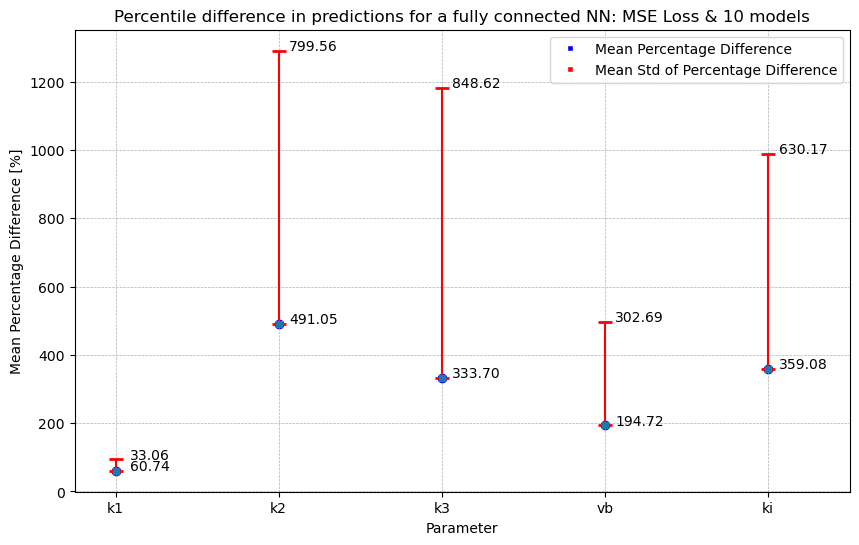

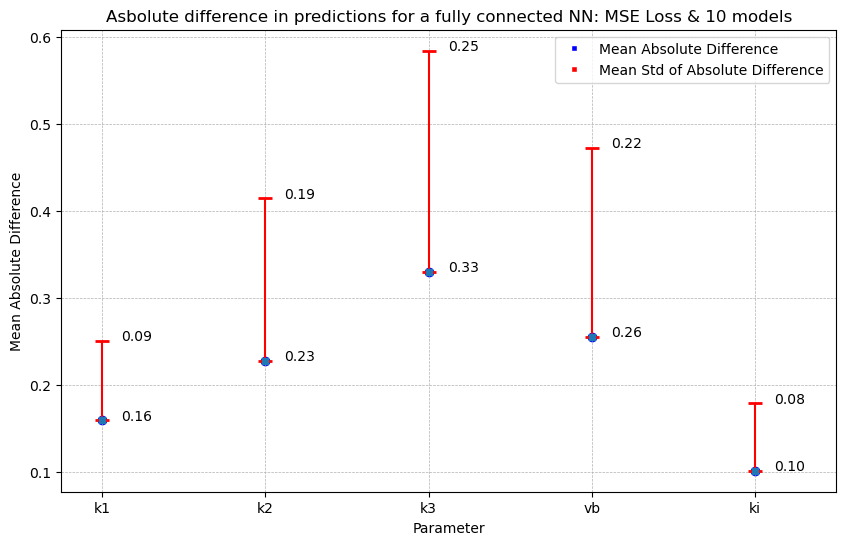

In [11]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from source.Train import training_single_model, training_parallel_models

# Set the random seed for reproducibility
np.random.seed(42)

# Load the data and define the loss function
data = np.load("data/Generated_Data/simulation_simple_0.01.npz")
model_class = FC_single
#loss = nn.MSELoss()
#loss = nn.L1Loss()
loss = TAC_loss

# Initialize lists to collect the arrays
mean_percentage_diffs = []
std_percentage_diffs = []
mean_absolute_diffs = []
std_absolute_diffs = []
for i in range(5):
    print(f"Training model {i + 1}")
    model, results = training_single_model(data, model_class, loss, batch_size=1028, lr=0.0001, patience=5, epochs=50, progress=True)
    # Append the results to the lists
    mean_percentage_diffs.append(results["mean_percentage_diff"])
    std_percentage_diffs.append(results["std_percentage_diff"])
    mean_absolute_diffs.append(results["mean_abs_diff"])
    std_absolute_diffs.append(results["std_abs_diff"])

# Convert lists to 2D numpy arrays
mean_percentage_diffs_array = np.array(mean_percentage_diffs)
std_percentage_diffs_array = np.array(std_percentage_diffs)
mean_absolute_diffs_array = np.array(mean_absolute_diffs)
std_absolute_diffs_array = np.array(std_absolute_diffs)

# Calculate the average of each column
mean_percentage_diffs_avg = np.mean(mean_percentage_diffs_array, axis=0)
std_percentage_diffs_avg = np.mean(std_percentage_diffs_array, axis=0)
mean_absolute_diffs_avg = np.mean(mean_absolute_diffs_array, axis=0)
std_absolute_diffs_avg = np.mean(std_absolute_diffs_array, axis=0)

# Print the average values for each column
print("Average of mean percentage differences:", mean_percentage_diffs_avg)
print("Average of std percentage differences:", std_percentage_diffs_avg)
print("Average of mean absolute differences:", mean_absolute_diffs_avg)
print("Average of std absolute differences:", std_absolute_diffs_avg)

# Custom parameter labels
parameters = ['k1', 'k2', 'k3', 'vb', 'ki']

# Plotting the percentile differences
plt.figure(figsize=(10, 6))
# Error bars for the standard deviation
errorbar_container = plt.errorbar(parameters, mean_percentage_diffs_avg, 
             yerr=[np.zeros_like(std_percentage_diffs_avg), std_percentage_diffs_avg], 
             fmt='s', capsize=5, capthick=2, ecolor='red', markersize=5, 
             linestyle='None', label='Average Std')

# Annotating each point with its value
for i, txt in enumerate(mean_percentage_diffs_avg):
    plt.annotate(f'{txt:.2f}', (parameters[i], mean_percentage_diffs_avg[i]), textcoords="offset points", xytext=(25,0), ha='center')
for i, txt in enumerate(std_percentage_diffs_avg):
    plt.annotate(f'{txt:.2f}', (parameters[i], mean_percentage_diffs_avg[i] + std_percentage_diffs_avg[i]), textcoords="offset points", xytext=(25,0), ha='center')

# Extending the graph to the right by adjusting x-axis limits
plt.xlim(-0.25, len(parameters)-0.5)  # Set dynamic limits based on the number of parameters

# Customizing the plot
plt.title('Percentile difference in predictions for a fully connected NN: MSE Loss & 10 models')
plt.xlabel('Parameter')
plt.ylabel('Mean Percentage Difference [%]')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Handling legend for both Average Difference and Average Std
plt.scatter(parameters, mean_percentage_diffs_avg, color='blue', label='Average Difference')
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=5, label='Mean Percentage Difference'),
                    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=5, label='Mean Std of Percentage Difference')],
           loc='best')

# Show plot
plt.show()

# Plotting the absolute differences
plt.figure(figsize=(10, 6))
# Error bars for the standard deviation
errorbar_container = plt.errorbar(parameters, mean_absolute_diffs_avg, 
             yerr=[np.zeros_like(std_absolute_diffs_avg), std_absolute_diffs_avg], 
             fmt='s', capsize=5, capthick=2, ecolor='red', markersize=5, 
             linestyle='None', label='Average Std')

# Annotating each point with its value
for i, txt in enumerate(mean_absolute_diffs_avg):
    plt.annotate(f'{txt:.2f}', (parameters[i], mean_absolute_diffs_avg[i]), textcoords="offset points", xytext=(25,0), ha='center')
for i, txt in enumerate(std_absolute_diffs_avg):
    plt.annotate(f'{txt:.2f}', (parameters[i], mean_absolute_diffs_avg[i] + std_absolute_diffs_avg[i]), textcoords="offset points", xytext=(25,0), ha='center')

# Extending the graph to the right by adjusting x-axis limits
plt.xlim(-0.25, len(parameters)-0.5)  # Set dynamic limits based on the number of parameters

# Customizing the plot
plt.title('Asbolute difference in predictions for a fully connected NN: MSE Loss & 10 models')
plt.xlabel('Parameter')
plt.ylabel('Mean Absolute Difference')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Handling legend for both Average Difference and Average Std
plt.scatter(parameters, mean_absolute_diffs_avg, color='blue', label='Average Difference')
plt.legend(handles=[plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=5, label='Mean Absolute Difference'),
                    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=5, label='Mean Std of Absolute Difference')],
           loc='best')

# Show plot
plt.show()

Parallel network

In [39]:

# Load simulated data from data/Generated_Data/simulation_advanced.npz
data = np.load("data/Generated_Data/simulation_simple_0.01.npz")
inputs = data["noisy_tacs"]
true_params = data["gt_parameters"]

# Convert data to PyTorch tensors
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
true_params_tensor = torch.tensor(true_params, dtype=torch.float32)

# Create TensorDataset
dataset = TensorDataset(inputs_tensor, true_params_tensor)

# Create DataLoader
batch_size = 1028  # Set batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the models for each parameter
models = [FC_parallel(in_features=inputs.shape[1]) for _ in range(4)]

# Optimizers (one for each model)
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

loss_function = nn.L1Loss()  # L1 loss for regression


# Training loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    for batch_inputs, batch_true_params in dataloader:
        for i, model in enumerate(models):
            optimizer = optimizers[i]
            optimizer.zero_grad()

            # Forward pass
            output_param = model(batch_inputs).squeeze()

            # Compute loss for the specific parameter
            #loss = compute_parameter_loss(output_param, batch_true_params[:, i], use_absolute=True)
            loss = loss_function(output_param, batch_true_params[:, i])

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            print(f"Parameter {i+1}, Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    

Parameter 1, Epoch [1/10], Loss: 0.5203
Parameter 2, Epoch [1/10], Loss: 0.4854
Parameter 3, Epoch [1/10], Loss: 0.2815
Parameter 4, Epoch [1/10], Loss: 0.6200
Parameter 1, Epoch [1/10], Loss: 0.4844
Parameter 2, Epoch [1/10], Loss: 0.5031
Parameter 3, Epoch [1/10], Loss: 0.2346
Parameter 4, Epoch [1/10], Loss: 0.6095
Parameter 1, Epoch [1/10], Loss: 0.4328
Parameter 2, Epoch [1/10], Loss: 0.3405
Parameter 3, Epoch [1/10], Loss: 0.2814
Parameter 4, Epoch [1/10], Loss: 0.5200
Parameter 1, Epoch [1/10], Loss: 0.3974
Parameter 2, Epoch [1/10], Loss: 0.3221
Parameter 3, Epoch [1/10], Loss: 0.2292
Parameter 4, Epoch [1/10], Loss: 0.4509
Parameter 1, Epoch [1/10], Loss: 0.3649
Parameter 2, Epoch [1/10], Loss: 0.3031
Parameter 3, Epoch [1/10], Loss: 0.1950
Parameter 4, Epoch [1/10], Loss: 0.4059
Parameter 1, Epoch [1/10], Loss: 0.3211
Parameter 2, Epoch [1/10], Loss: 0.2653
Parameter 3, Epoch [1/10], Loss: 0.2026
Parameter 4, Epoch [1/10], Loss: 0.3823
Parameter 1, Epoch [1/10], Loss: 0.2924


In [40]:
def ki_macro(k1, k2, k3):
    """
    Computes the macro parameter k_i from the parameters k1, k2, and k3.

    Parameters:
    k1 (float): The first parameter.
    k2 (float): The second parameter.
    k3 (float): The third parameter.

    Returns:
    float: The macro rate constant k_i.
    """
    ki = (k1 * k2) / (k2 + k3)
    return ki

In [44]:
# Load the data and define the loss function
data = np.load("data/Generated_Data/simulation_simple_0.01.npz")
model_class = FC_parallel
#loss = nn.MSELoss()
loss = nn.L1Loss()

# Initialize lists to collect the arrays
mean_percentage_diffs = []
std_percentage_diffs = []
mean_absolute_diffs = []
std_absolute_diffs = []

for i in range(5):
    print(f"Training model {i + 1}")
    model, results = training_parallel_models(data, model_class, loss, batch_size=1028, lr=0.001, patience=5, epochs=50, progress=True)
    # Append the results to the lists
    mean_percentage_diffs.append(results["mean_percentage_diff"])
    std_percentage_diffs.append(results["std_percentage_diff"])
    mean_absolute_diffs.append(results["mean_abs_diff"])
    std_absolute_diffs.append(results["std_abs_diff"])

Training model 1
Epoch 1, Validation Loss: 0.5520684327930212
Epoch 2, Validation Loss: 0.4110001102089882
Epoch 3, Validation Loss: 0.41077477671206
Epoch 4, Validation Loss: 0.3753576874732971
Epoch 5, Validation Loss: 0.31786329858005047
Epoch 6, Validation Loss: 0.27795221470296383
Epoch 7, Validation Loss: 0.26266735792160034
Epoch 8, Validation Loss: 0.2727242447435856
Epoch 9, Validation Loss: 0.21969454968348145
Epoch 10, Validation Loss: 0.2249616291373968
Epoch 11, Validation Loss: 0.21842085244134068
Epoch 12, Validation Loss: 0.2623043768107891
Epoch 13, Validation Loss: 0.24786153715103865
Epoch 14, Validation Loss: 0.20602081855759025
Epoch 15, Validation Loss: 0.19176573771983385
Epoch 16, Validation Loss: 0.19247500132769346
Epoch 17, Validation Loss: 0.15768269542604685
Epoch 18, Validation Loss: 0.2293537964578718
Epoch 19, Validation Loss: 0.16852528718300164
Epoch 20, Validation Loss: 0.16431082808412611
Epoch 21, Validation Loss: 0.19061642489396036
Epoch 22, Valid

KeyboardInterrupt: 